In [1]:
!pip install split-folders


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
DATA_DIR = 'asl_dataset'
OUTPUT_DIR = 'asl_split_dataset' 

# splitfolders.ratio(DATA_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.64, 0.16, 0.2))

In [4]:
IMAGE_SIZE = (224, 224, 3)  
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.2

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [5]:
num_classes = 36

In [6]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

Found 1581 files belonging to 36 classes.
Found 395 files belonging to 36 classes.
Found 539 files belonging to 36 classes.


In [8]:
train_dataset = train_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
val_dataset = val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
test_dataset = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [9]:
base_model = MobileNet(input_shape=IMAGE_SIZE, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,772,132 (14.39 MB)

 Trainable params: 543,268 (2.07 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=50,            
    restore_best_weights=True  
)

In [12]:
history_initial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,  
    callbacks=[early_stopping],
    verbose=1 
)

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.2042 - loss: 3.2844 - val_accuracy: 0.7367 - val_loss: 1.1652
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.6281 - loss: 1.1994 - val_accuracy: 0.8228 - val_loss: 0.7105
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.7682 - loss: 0.7465 - val_accuracy: 0.8354 - val_loss: 0.5517
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.8255 - loss: 0.5478 - val_accuracy: 0.8835 - val_loss: 0.4249
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.8544 - loss: 0.4428 - val_accuracy: 0.8785 - val_loss: 0.3891
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.8963 - loss: 0.3429 - val_accuracy: 0.9038 - val_loss: 0.3413
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.9035 - loss: 0.3119 - val_accuracy: 0.8987 - val_loss: 0.3009
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.9220 - loss: 0

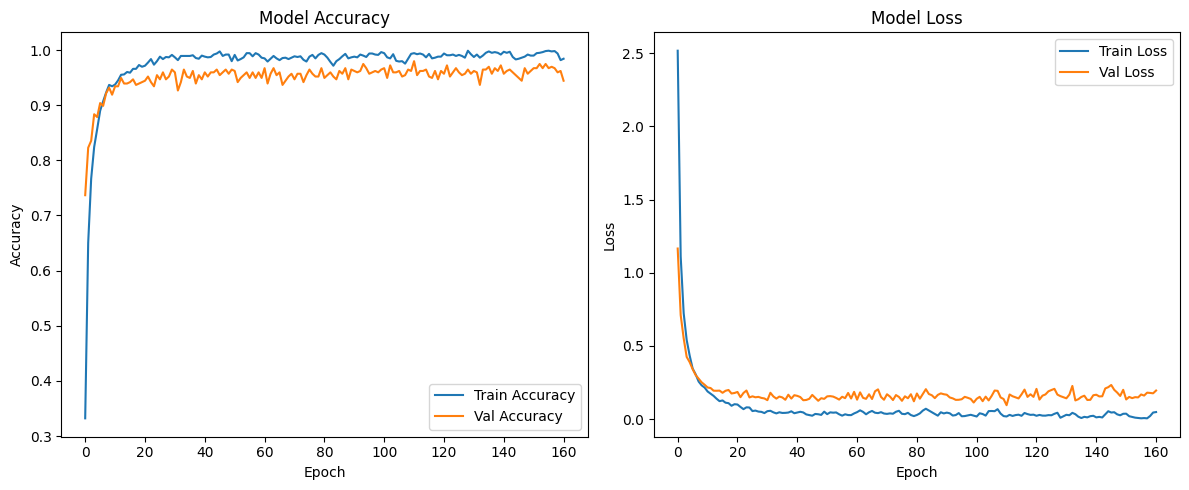

In [13]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history_initial)

In [14]:
for layer in base_model.layers[-20:]:  
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
early_stopping_fine_tunning = EarlyStopping(
    monitor='val_loss',    
    patience=100,            
    restore_best_weights=True  
)

In [16]:
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2500,
    initial_epoch=history_initial.epoch[-1],  
    callbacks=[early_stopping],
    verbose=1  
)

Epoch 161/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.5640 - loss: 3.9153 - val_accuracy: 0.9494 - val_loss: 0.2010
Epoch 162/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step - accuracy: 0.7016 - loss: 1.9033 - val_accuracy: 0.9342 - val_loss: 0.3133
Epoch 163/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.7779 - loss: 1.1425 - val_accuracy: 0.9266 - val_loss: 0.3604
Epoch 164/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - accuracy: 0.8476 - loss: 0.6362 - val_accuracy: 0.9241 - val_loss: 0.3495
Epoch 165/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - accuracy: 0.8825 - loss: 0.4785 - val_accuracy: 0.9291 - val_loss: 0.3465
Epoch 166/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.8834 - loss: 0.4089 - val_accuracy: 0.9316 - val_loss: 0.3311
Epoch 167/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 386ms/step - accuracy: 0.9058 - loss: 0.3129 - val_accuracy: 0.9291 - val_loss: 0.3159
Epoch 168/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 

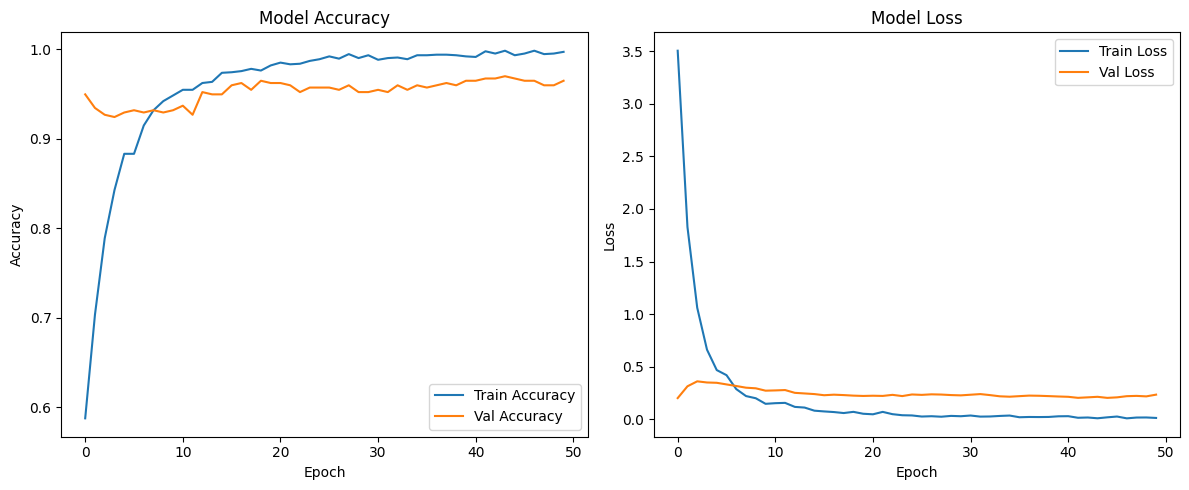

In [17]:
plot_training_history(history_fine_tune)

In [18]:
model.save('fine_tuned_model3.keras')

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.9421 - loss: 0.1672
Test Accuracy: 95.55%
Test Loss: 0.1333
